In [ ]:
import numpy as np 
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from skimage.io import imread,imshow
import matplotlib.image as mpimg 
from scipy.ndimage import gaussian_filter
import scipy
from random import sample
import sklearn.model_selection as skl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix


Load the data:

In [ ]:

data = pd.read_csv('/content/sample_labels.csv')

data.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168
4,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139


In [ ]:
## Add path to the image
data = pd.read_csv('/content/sample_labels.csv')
image_paths = {os.path.basename(t): t for t in 
                    glob(os.path.join('data','*.png'))}
print('Scans found:', len(image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(image_paths.get)

pd.set_option('display.max_columns', None)
data['path']

Scans found: 74 , Total Headers 74


0     data/00000013_005.png
1     data/00000013_026.png
2     data/00000017_001.png
3     data/00000032_001.png
4     data/00000042_002.png
              ...          
69    data/00022192_032.png
70    data/00026179_003.png
71    data/00027725_073.png
72    data/00027757_002.png
73    data/00028924_005.png
Name: path, Length: 74, dtype: object

In [ ]:
##  table with binary indicators of certain diseases:

all_labels=np.unique(list(chain(*data['Finding Labels'].map(lambda y: y.split('|')).tolist())))
all_labels=[t for t in all_labels if len(t)>0]
print(all_labels)
for label in all_labels:
    if len(label)>1:
        data[label] = data['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

        
data.head()


['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,data/00000013_005.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,data/00000013_026.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,data/00000017_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,data/00000032_001.png,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139,data/00000042_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
##  'pneumonia_class' that will allow us to look at positive(pnuemonia) or negative(without pnuemonia)

data['pneumonia_class']=data['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})
data[data['pneumonia_class']== 'Positive']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
44,00008154_000.png,Atelectasis|Consolidation|Mass|Pneumonia,0,8154,053Y,F,PA,2048,2500,0.168,0.168,data/00008154_000.png,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Positive
45,00008470_008.png,Pneumonia,8,8470,030Y,F,AP,2500,2048,0.171,0.171,data/00008470_008.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
46,00008763_001.png,Nodule|Pneumonia,1,8763,061Y,M,PA,2500,2048,0.168,0.168,data/00008763_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Positive
47,00010552_005.png,Infiltration|Pneumonia,5,10552,039Y,M,PA,2622,2991,0.143,0.143,data/00010552_005.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
48,00011104_004.png,Infiltration|Nodule|Pneumonia,4,11104,060Y,M,PA,2992,2991,0.143,0.143,data/00011104_004.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Positive
49,00011251_010.png,Infiltration|Pneumonia,10,11251,076Y,M,AP,2500,2048,0.168,0.168,data/00011251_010.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
50,00011702_043.png,Pneumonia,43,11702,026Y,F,AP,2500,2048,0.168,0.168,data/00011702_043.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
51,00012834_113.png,Consolidation|Edema|Effusion|Pneumonia,113,12834,033Y,M,AP,2500,2048,0.168,0.168,data/00012834_113.png,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
52,00013249_033.png,Cardiomegaly|Edema|Infiltration|Pneumonia,33,13249,015Y,M,AP,2500,2048,0.168,0.168,data/00013249_033.png,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
53,00013952_000.png,Atelectasis|Pneumonia,0,13952,059Y,M,PA,2500,2048,0.168,0.168,data/00013952_000.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive


Create your training and testing data:

In [ ]:
def create_splits(df_name):
    
    t_data, v_data=skl.train_test_split(df_name,
                                              test_size=0.2,
                                             stratify=df_name['Pneumonia'])
    
    #balance train_data
    pos_ind=t_data[t_data['pneumonia_class']=='Positive'].index.tolist()
    neg_ind=t_data[t_data['pneumonia_class']=='Negative'].index.tolist()
    num_sample = sample(neg_ind,len(pos_ind))
    t_data=t_data.loc[pos_ind+num_sample]
    
    vpos_ind=v_data[v_data['pneumonia_class']=='Positive'].index.tolist()
    vneg_ind=v_data[v_data['pneumonia_class']=='Negative'].index.tolist()
    vneg_sample = sample(vneg_ind,len(vpos_ind))
    v_data=v_data.loc[vpos_ind+vneg_sample]
    
    return t_data, v_data


In [ ]:
t_data, v_data = create_splits(data)

In [ ]:
(t_data['pneumonia_class']=='Positive').value_counts()

True     24
False    24
Name: pneumonia_class, dtype: int64

In [ ]:

(v_data['pneumonia_class']=='Negative').value_counts()


True     6
False    6
Name: pneumonia_class, dtype: int64

train_data and val_data have the correct number of Pneuominia-positive and Pneumonia-negative cases in each set.

In [ ]:
v_data['Patient Gender'].value_counts()


M    7
F    5
Name: Patient Gender, dtype: int64

In [ ]:
t_data['View Position'].value_counts()

AP    25
PA    23
Name: View Position, dtype: int64

In [ ]:
v_data['View Position'].value_counts()

AP    8
PA    4
Name: View Position, dtype: int64

Now we can begin our model-building & training


In [ ]:
def my_image_augmentation_train():
    
    
    my_train_ig = ImageDataGenerator(rescale = 1./255,
                                      horizontal_flip = True,
                                      height_shift_range = 0.1,
                                      width_shift_range = 0.1,
                                      rotation_range = 15,
                                      shear_range = 0.1,
                                      zoom_range = 0.1, 
                                      samplewise_center = True,
                                      samplewise_std_normalization = True
                                     )
    return my_train_ig

def my_image_augmentation_val():
    my_val_ig = ImageDataGenerator(rescale = 1./255.,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True
                                    )
    return my_val_ig


def make_train_gen(my_train_ig, train_df):
    
    
    t_gen = my_train_ig.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224,224), 
                                          batch_size = 16
                                          )

    return t_gen


def make_val_gen(my_val_ig, val_df):
    
    v_gen = my_val_ig.flow_from_dataframe(dataframe = val_df, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = (224,224), 
                                              batch_size = 32,
                                              shuffle=False
                                             ) 
    
    return v_gen

In [ ]:

v_gen = make_val_gen(my_image_augmentation_val(),v_data)
valX, valY = v_gen.next()


Found 12 validated image filenames belonging to 2 classes.


Found 48 validated image filenames belonging to 2 classes.
Batch Mean: 6.2848436e-08 Batch Std: 0.99999565


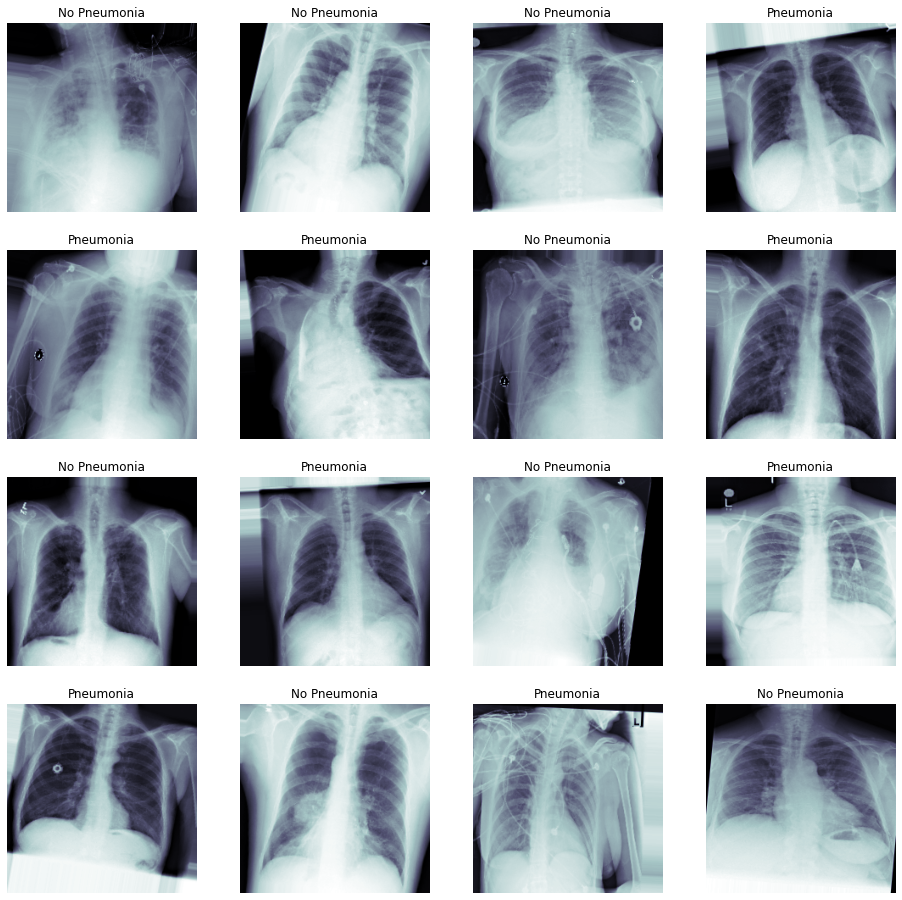

In [ ]:

t_idg = my_image_augmentation_train()
t_gen = make_train_gen(t_idg, t_data)

t_x, t_y = next(t_gen)
print("Batch Mean: " + str(t_x.mean()) + " Batch Std: " + str(t_x.std()))
figre, m_ax = plt.subplots(4,4, figsize = (16,16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_ax.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')


In [ ]:
def load_pretrained_vgg_model(layer_of_interest):
    
    model = VGG16(include_top=True, weights='imagenet')
    tsfr_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs = model.input, outputs = tsfr_layer.output)
    
    for layer in vgg_model.layers[0:-2]:
        layer.trainable = False
    
    return vgg_model


In [ ]:
def build_my_model(pretrained_model):
    
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    
    
    return my_model




In [ ]:
weight_path="/content/weight_path".format('xray_class')

checkpnt = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

erly = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callb_l = [checkpnt, erly]


In [ ]:
## train your model
vgg_model = load_pretrained_vgg_model('block5_pool')
my_model = build_my_model(vgg_model)
hsty = my_model.fit_generator(t_gen, 
                           validation_data = v_gen, 
                           epochs = 10,
                           callbacks = callb_l)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 2.6542 - binary_accuracy: 0.4583
Epoch 00001: val_loss improved from inf to 0.69162, saving model to /content/weight_path
3/3 [==============================] - 36s 13s/step - loss: 2.6542 - binary_accuracy: 0.4583 - val_loss: 0.6916 - val_binary_accuracy: 0.4167
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 1.9350 - binary_accuracy: 0.4583
Epoch 00002: val_loss did not improve from 0.69162
3/3 [==============================] - 33s 12s/step - loss: 1.9350 - binary_accuracy: 0.4583 - val_loss: 0.9027 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.9710 - binary_accuracy: 0.5208
Epoch 00003: val_loss improved from 0.69162 to 0.68963, saving model to /content/weight_path
3/3 [==============================] - 36s 13s/step - loss: 0.9710 - binary_accuracy: 0.5208 - val_loss: 0.6896 - val_binary_accuracy: 0.3333
Epoch 4/10
3/3 [============================

In [ ]:
def plot_history(hsty,epoch):
    plt.style.use('ggplot')
    plt.figure(figsize=(12,12))
    plt.style.use('ggplot')
    plt.plot(range(epoch),hsty.history['loss'],label='Loss', color='red')
    plt.plot(range(epoch),hsty.history['val_loss'],label='Validation_Loss', color = 'blue')
    plt.plot(range(epoch),hsty.history['binary_accuracy'],label='Binary_Accuracy',color='green')
    plt.plot(range(epoch),hsty.history['val_binary_accuracy'],label='Validation_Bin_Accuracy',color='black')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.show()

    return


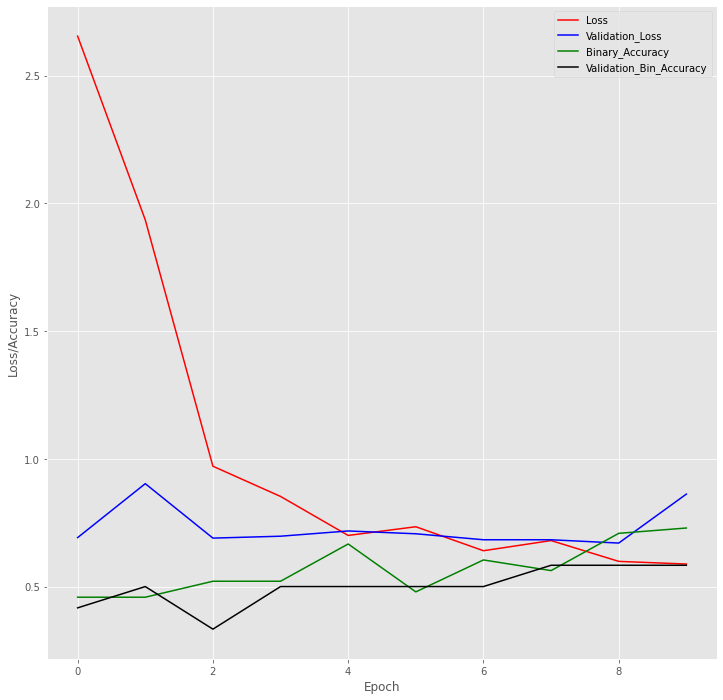

In [ ]:
plot_history(hsty,10)

In [ ]:
performance = []


In [ ]:
hsty_df=pd.DataFrame(hsty.history)
performance.append(hsty_df[hsty_df['val_loss']==min(hsty_df['val_loss'])])
performance


[      loss  binary_accuracy  val_loss  val_binary_accuracy
 8  0.59858         0.708333   0.67022             0.583333]

In [ ]:
def build_my_model2(pretrained_model):
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(2048, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
     
    return my_model

In [ ]:
#Train Model #2 with Dense and Dropout Layer
vgg_model = load_pretrained_vgg_model('block5_pool')
my_model2 = build_my_model2(vgg_model)
hsty2 = my_model2.fit_generator(t_gen, 
                           validation_data = v_gen, 
                           epochs = 10,
                           callbacks = callb_l)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 2.4140 - binary_accuracy: 0.5000
Epoch 00001: val_loss did not improve from 0.67022
3/3 [==============================] - 38s 12s/step - loss: 2.4140 - binary_accuracy: 0.5000 - val_loss: 0.8272 - val_binary_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 3.0246 - binary_accuracy: 0.5000
Epoch 00002: val_loss did not improve from 0.67022
3/3 [==============================] - 34s 12s/step - loss: 3.0246 - binary_accuracy: 0.5000 - val_loss: 0.8431 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 2.0479 - binary_accuracy: 0.4375
Epoch 00003: val_loss did not improve from 0.67022
3/3 [==============================] - 34s 12s/step - loss: 2.0479 - binary_accuracy: 0.4375 - val_loss: 0.7289 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.9220 - binary_accuracy: 0.5208
Epoch 00004: val_loss did

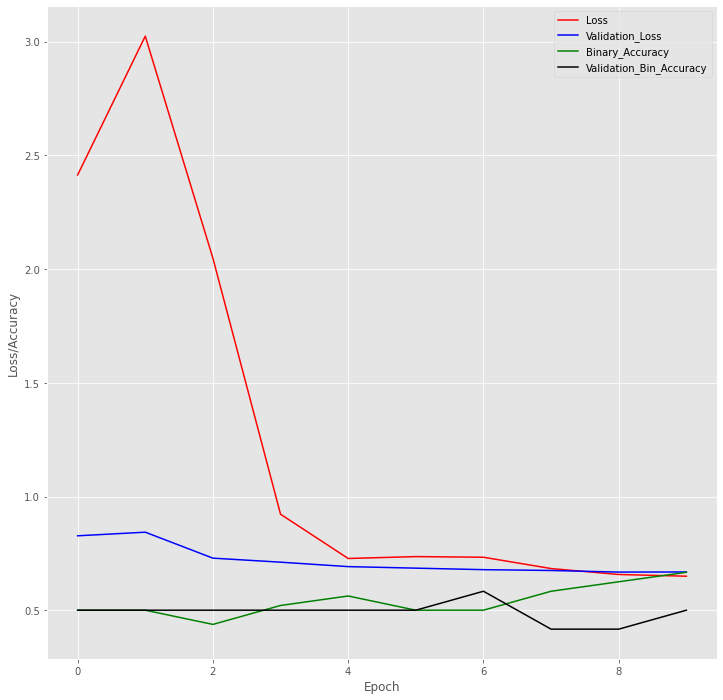

In [ ]:
plot_history(hsty2,10)

In [ ]:
hsty2_df=pd.DataFrame(hsty2.history)
performance.append(hsty2_df[hsty2_df['val_loss']==min(hsty2_df['val_loss'])])
performance

[      loss  binary_accuracy  val_loss  val_binary_accuracy
 8  0.59858         0.708333   0.67022             0.583333,
        loss  binary_accuracy  val_loss  val_binary_accuracy
 8  0.657061            0.625   0.66766             0.416667]

In [ ]:
def build_my_model3(pretrained_model):
    
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(2048, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
     
    return my_model

In [ ]:
#Train Model3 
vgg_model = load_pretrained_vgg_model('block5_pool')
my_model3 = build_my_model3(vgg_model)
hsty3 = my_model3.fit_generator(t_gen, 
                           validation_data = v_gen, 
                           epochs = 10,
                           callbacks = callb_l)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 1.2177 - binary_accuracy: 0.5000
Epoch 00001: val_loss did not improve from 0.66766
3/3 [==============================] - 38s 12s/step - loss: 1.2177 - binary_accuracy: 0.5000 - val_loss: 0.7224 - val_binary_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.8812 - binary_accuracy: 0.6042
Epoch 00002: val_loss did not improve from 0.66766
3/3 [==============================] - 34s 12s/step - loss: 0.8812 - binary_accuracy: 0.6042 - val_loss: 0.8103 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.9525 - binary_accuracy: 0.5417
Epoch 00003: val_loss did not improve from 0.66766
3/3 [==============================] - 34s 12s/step - loss: 0.9525 - binary_accuracy: 0.5417 - val_loss: 0.7372 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.9065 - binary_accuracy: 0.5625
Epoch 00004: val_loss did

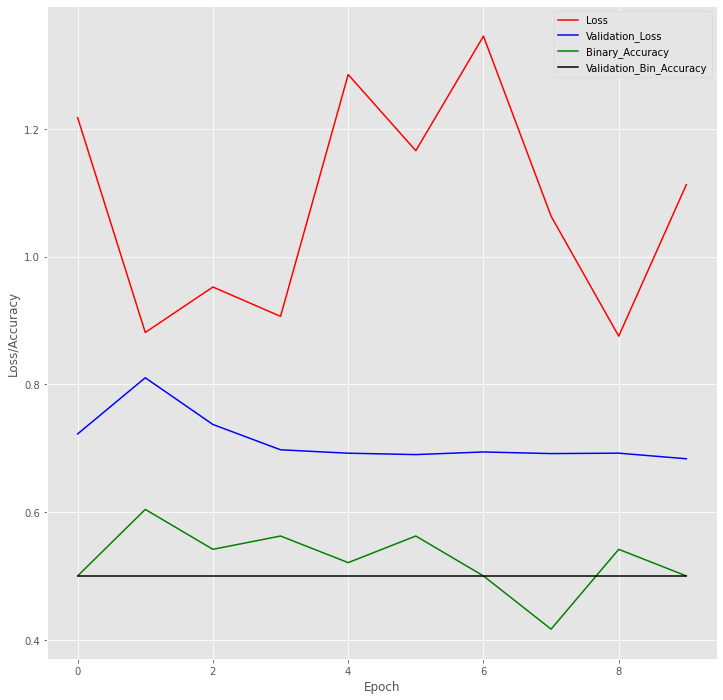

In [ ]:
model3_plot = plot_history(hsty3,10)

In [ ]:
hsty3_df=pd.DataFrame(hsty3.history)
performance.append(hsty3_df[hsty3_df['val_loss']==min(hsty3_df['val_loss'])])
performance

[      loss  binary_accuracy  val_loss  val_binary_accuracy
 8  0.59858         0.708333   0.67022             0.583333,
        loss  binary_accuracy  val_loss  val_binary_accuracy
 8  0.657061            0.625   0.66766             0.416667,
        loss  binary_accuracy  val_loss  val_binary_accuracy
 9  1.112839              0.5  0.683485                  0.5]

After training for some time, look at the performance of your model by plotting some performance statistics:


In [ ]:
vgg_model = load_pretrained_vgg_model('block5_pool')
my_model1 = build_my_model(vgg_model)
my_model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_14 (Dense)            (None, 1024)              25691136  
                                                                 
 dropout_11 (Dropout)        (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 256)              